In [2]:
import os.path as op
import os
# import sys
import numpy as np
import pandas as pd
import mne


In [2]:
data_path =  'D:\projects\WM_GRID\DATA\mg99a'
cal_path = 'D:\projects\WM_GRID\DATA\ctc'
sss_path = 'D:\projects\WM_GRID\DATA\sss'
file_name = 'mg99a01'
raw_fname_in = op.join(data_path, file_name + '.fif')
raw = mne.io.read_raw_fif(
    raw_fname_in,
    allow_maxshield=True,
    preload=False,
    verbose=True)

Opening raw data file D:\projects\WM_GRID\DATA\mg99a\mg99a01.fif...


C:\Users\qiaol\AppData\Local\Temp\ipykernel_616\2854599378.py:6: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\mg99a01.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(


    Read a total of 6 projection items:
        grad_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
    Range : 72000 ... 946999 =     72.000 ...   946.999 secs
Ready.


In [3]:
crosstalk_file = op.join(cal_path, 'ct_sparse.fif')
fine_cal_file = op.join(sss_path, 'sss_cal.dat')
print(fine_cal_file)
print(crosstalk_file)

D:\projects\WM_GRID\DATA\sss\sss_cal.dat
D:\projects\WM_GRID\DATA\ctc\ct_sparse.fif


In [4]:
from mne.preprocessing import find_bad_channels_maxwell
import matplotlib.pyplot as plt
crosstalk_file = op.join(cal_path, 'ct_sparse.fif')
fine_cal_file = op.join(sss_path, 'sss_cal.dat')
# Detect bad channels
raw.info['bads'] = []
raw_check = raw.copy()
auto_noisy_chs, auto_flat_chs, auto_scores = find_bad_channels_maxwell(
            raw_check, 
            cross_talk=crosstalk_file, 
            calibration=fine_cal_file,
            return_scores=True,
            verbose=True)

Applying low-pass filter with 40.0 Hz cutoff frequency ...
Reading 0 ... 874999  =      0.000 ...   874.999 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    4.6s finished


Scanning for bad channels in 175 intervals (5.0 sec) ...
102 of 102 magnetometer types replaced with T3.
    No bad MEG channels
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.4° (max: 1.9°)
    Automatic origin fit: head of radius 86.6 mm
    Using origin -1.8, 7.2, 49.6 mm in the head frame
        Interval   1:    0.000 -    4.999
            Flat ( 2): MEG1241 MEG2641
        Interval   2:    5.000 -    9.999
            Flat ( 2): MEG1241 MEG2641
        Interval   3:   10.000 -   14.999
            Flat ( 2): MEG1241 MEG2641
        Interval   4:   15.000 -   19.999
            Flat ( 2): MEG1241 MEG2641
        Interval   5:   20.000 -   24.999
            Flat ( 2): MEG1241 MEG2641
        Interval   6:   25.000 -   29.999
            Flat ( 2): MEG1241 MEG2641
        Interval   7:   30.000 -   34.999
            Flat ( 2): MEG1241 MEG26

In [5]:
print('noisy =', auto_noisy_chs)
print('flat = ', auto_flat_chs)
raw.info['bads'].extend(auto_noisy_chs + auto_flat_chs)
print('bads =', raw.info['bads'])

noisy = ['MEG0413']
flat =  ['MEG1241', 'MEG2641']
bads = ['MEG0413', 'MEG1241', 'MEG2641']


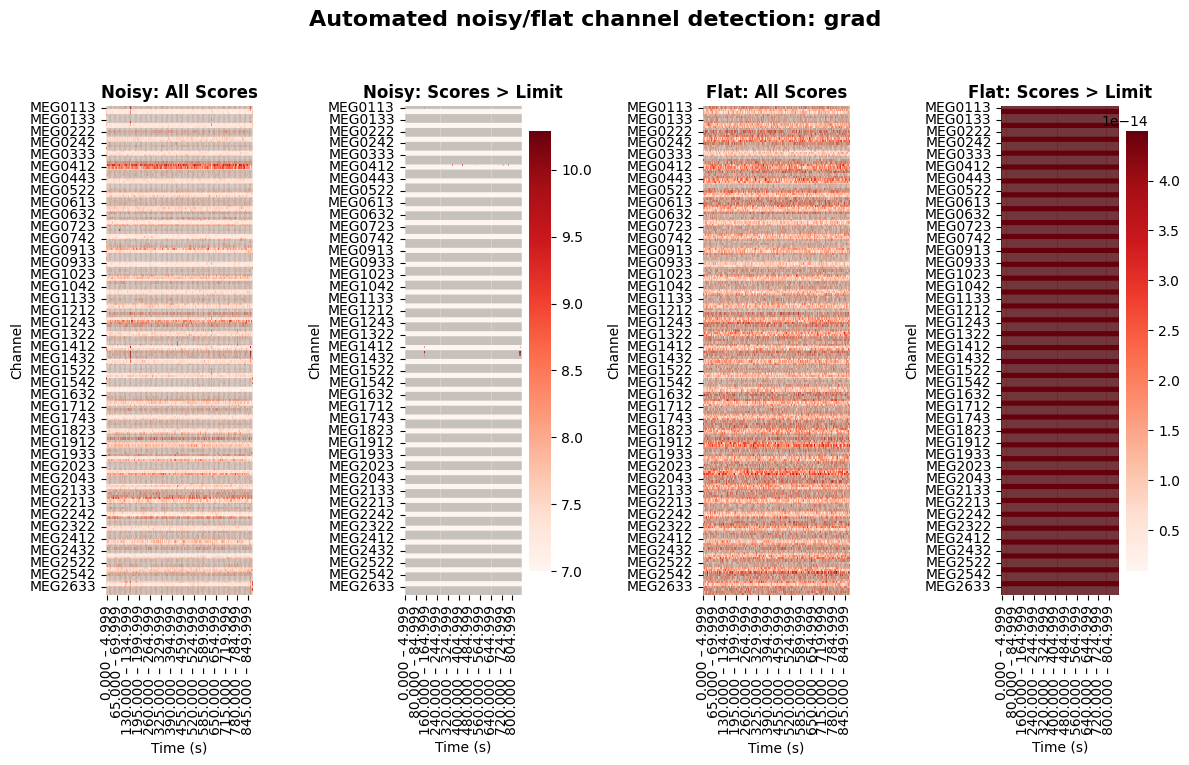

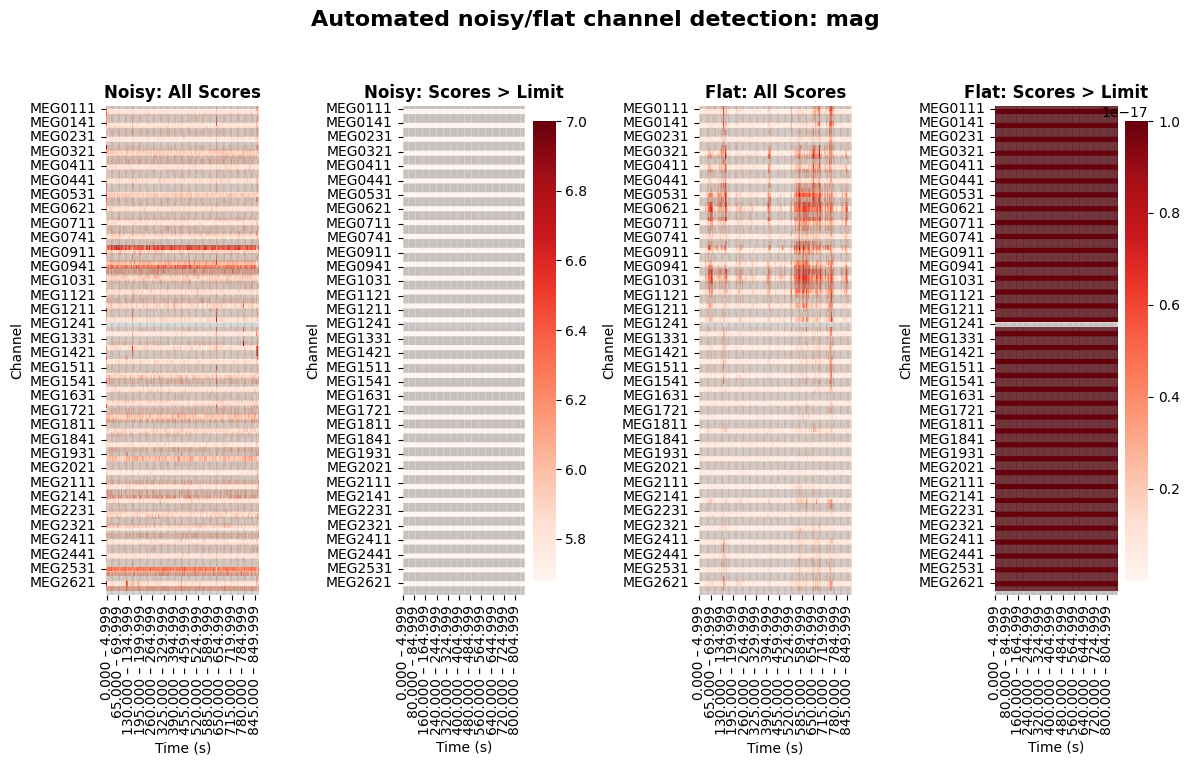

In [6]:
# Visualize the scoring used to classify channels as noisy or flat
import seaborn as sns
def viz_badch_scores(auto_scores, ch_type):
    fig, ax = plt.subplots(1, 4, figsize=(12, 8))
    fig.suptitle(f'Automated noisy/flat channel detection: {ch_type}',
                  fontsize=16, fontweight='bold')
    
    #### Noisy channels ####
    ch_subset = auto_scores['ch_types'] == ch_type
    ch_names = auto_scores['ch_names'][ch_subset]
    scores = auto_scores['scores_noisy'][ch_subset]
    limits = auto_scores['limits_noisy'][ch_subset]
    bins = auto_scores['bins']  #the windows that were evaluated
    
    # Label each segment by its start and stop time (3 digits / 1 ms precision)
    bin_labels = [f'{start:3.3f} – {stop:3.3f}' 
                  for start, stop in bins]
    
    # Store  data in DataFrame
    data_to_plot = pd.DataFrame(data=scores,
                                columns=pd.Index(bin_labels, name='Time (s)'),
                                index=pd.Index(ch_names, name='Channel'))
    
    # First, plot the raw scores
    sns.heatmap(data=data_to_plot, 
                cmap='Reds', 
                cbar=False,
                # cbar_kws=dict(label='Score'),
                ax=ax[0])
    [ax[0].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(bins))]
    ax[0].set_title('Noisy: All Scores', fontweight='bold')

    # Second, highlight segments that exceeded the 'noisy' limit
    sns.heatmap(data=data_to_plot,
                vmin=np.nanmin(limits),
                cmap='Reds', 
                cbar=True, 
                # cbar_kws=dict(label='Score'), 
                ax=ax[1])
    [ax[1].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(bins))]
    ax[1].set_title('Noisy: Scores > Limit', fontweight='bold')
    
    #### Flat channels ####
    ch_subset = auto_scores['ch_types'] == ch_type
    ch_names = auto_scores['ch_names'][ch_subset]
    scores = auto_scores['scores_flat'][ch_subset]
    limits = auto_scores['limits_flat'][ch_subset]
    bins = auto_scores['bins']  #the windows that were evaluated
    
    # Label each segment by its start and stop time (3 digits / 1 ms precision)
    bin_labels = [f'{start:3.3f} – {stop:3.3f}' 
                  for start, stop in bins]
    
    # Store  data in DataFrame
    data_to_plot = pd.DataFrame(data=scores,
                                columns=pd.Index(bin_labels, name='Time (s)'),
                                index=pd.Index(ch_names, name='Channel'))
    
    # First, plot the raw scores
    sns.heatmap(data=data_to_plot, 
                cmap='Reds', 
                cbar=False,
                # cbar_kws=dict(label='Score'),
                ax=ax[2])
    [ax[2].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(bins))]
    ax[2].set_title('Flat: All Scores', fontweight='bold')

    # Second, highlight segments that exceeded the 'noisy' limit
    sns.heatmap(data=data_to_plot,
                vmax=np.nanmax(limits),
                cmap='Reds', 
                cbar=True,
                # cbar_kws=dict(label='Score'), 
                ax=ax[3])
    [ax[3].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(bins))]
    ax[3].set_title('Flat: Scores > Limit', fontweight='bold')
    
    # Fit figure title to not overlap with the subplots
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    return fig

ch_type = 'grad'
fig = viz_badch_scores(auto_scores, ch_type)

ch_type = 'mag'
fig = viz_badch_scores(auto_scores, ch_type)


In [7]:
# Fix Elekta magnetometer coil types
raw.fix_mag_coil_types()

102 of 102 magnetometer types replaced with T3.


<Raw | mg99a01.fif, 310 x 875000 (875.0 s), ~6.5 MB, data not loaded>

In [8]:
raw_sss = mne.preprocessing.maxwell_filter(
    raw,
    cross_talk=crosstalk_file, 
    calibration=fine_cal_file,
    st_duration=None,
    #coord_frame="meg", #only for empy room, comment it if using HPI
    verbose=True)

Maxwell filtering raw data
    Bad MEG channels being reconstructed: ['MEG0413', 'MEG1241', 'MEG2641']
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.4° (max: 1.9°)
    Automatic origin fit: head of radius 86.6 mm
    Using origin -1.8, 7.2, 49.6 mm in the head frame
        Using 89/95 harmonic components for    0.000  (74/80 in, 15/15 out)
    Loading raw data from disk
    Processing 87 data chunks
[done]


Using matplotlib as 2D backend.


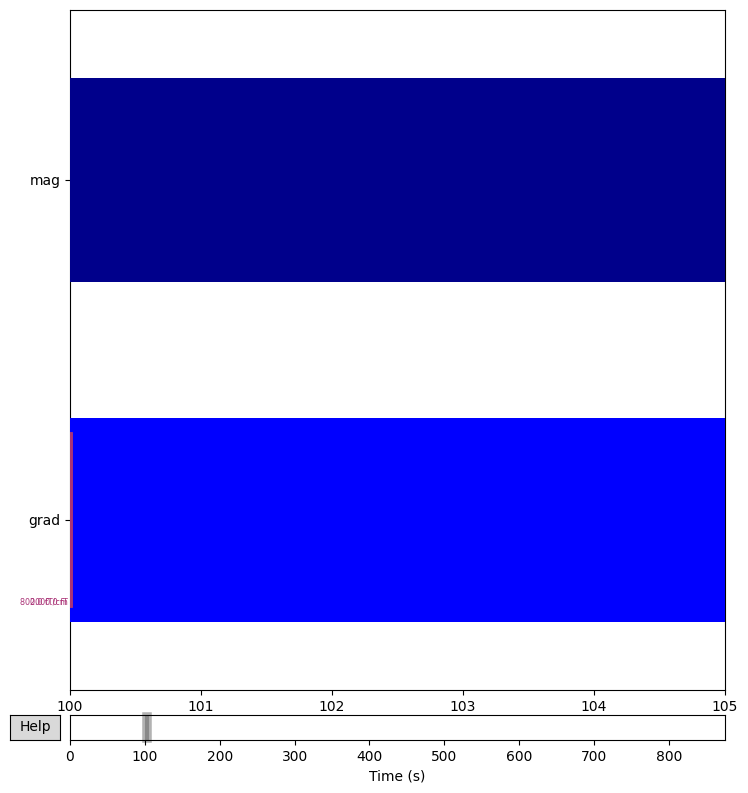

Effective window size : 0.256 (s)


d:\projects\WM_GRID\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


In [9]:
fig = raw_sss.copy().pick(['meg']).plot(duration=5,
                                        start=100,
                                        butterfly=True)
fig1 = raw_sss.compute_psd(picks = ['meg'],fmin = 1,fmax = 100).plot()

In [ ]:
method = 'sss'
file_name = 'mg99a01'
out_path = 'D:\projects\WM_GRID\DATA\mg99a_out'
fname_out = op.join(out_path,
                    file_name + '_' + method + '.fif')
raw_sss.save(fname_out, overwrite=True)

In [ ]:
eog_events = mne.preprocessing.find_eog_events(raw_sss)
onsets = (eog_events[:, 0] - raw.first_samp) / raw.info['sfreq'] - 0.25
durations = [0.5] * len(eog_events)
descriptions = ['Blink'] * len(eog_events)
            # Annotate events
annot_blink = mne.Annotations(
            onsets, 
            durations,
            descriptions)
                # orig_time=raw.info['meas_date'])
            
            # Add blinks to annotations list


In [11]:
from mne.preprocessing import annotate_muscle_zscore
# Notch filter
raw_muscle = raw_sss.copy().notch_filter([50, 100])
threshold_muscle = 10
annot_muscle, scores_muscle = annotate_muscle_zscore(
            raw_muscle, 
            ch_type="mag", 
            threshold=threshold_muscle, 
            min_length_good=0.2,
            filter_freq=[110, 140])


Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.4s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1.1e+02 - 1.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 110.00
- Lower transition bandwidth: 27.50 Hz (-6 dB cutoff frequency: 96.25 Hz)
- Upper passband edge: 140.00 Hz
- Upper transition bandwidth: 35.00 Hz (-6 dB cutoff frequency: 157.50 Hz)
- Filter length: 121 samples (0.121 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 102 out of 102 | elapsed:    2.6s finished


Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 1651 samples (1.651 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 3301 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    4.6s finished


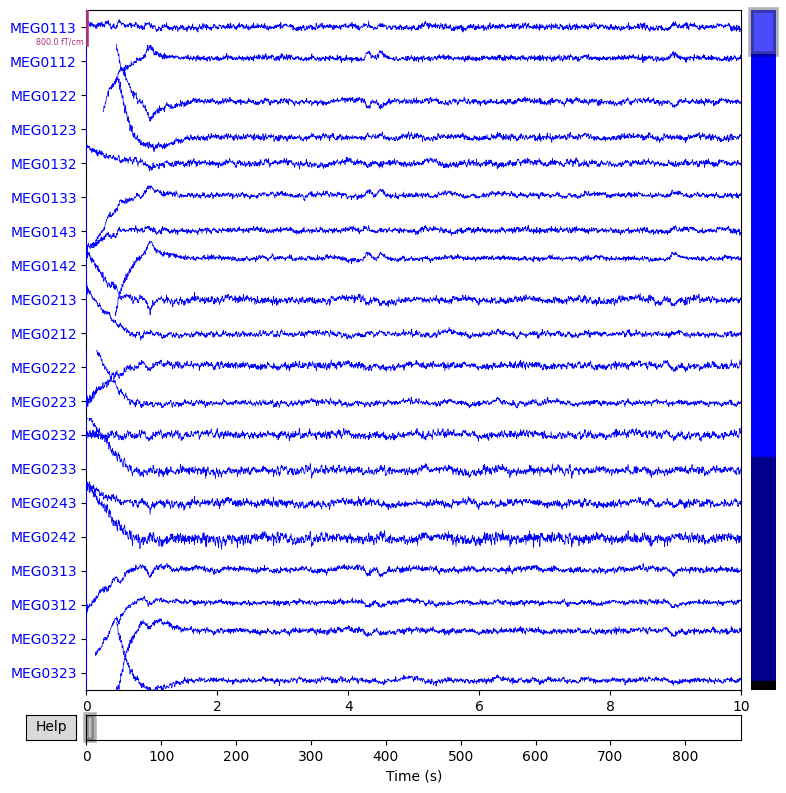

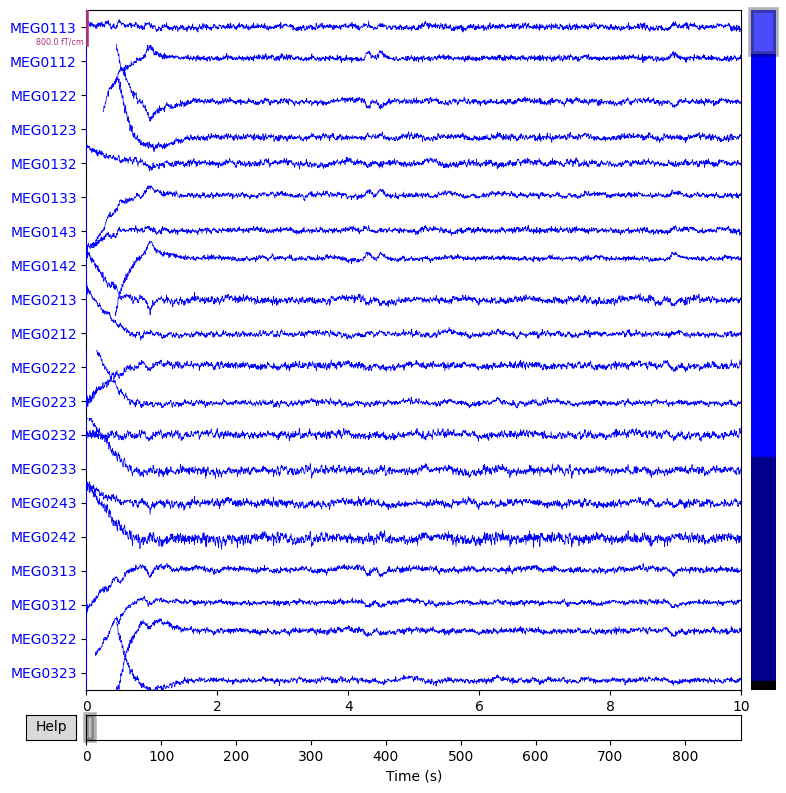

In [13]:
raw_muscle.copy().filter(1,100).plot()

[Text(0.5, 0, 'time, (s)'),
 Text(0, 0.5, 'zscore'),
 Text(0.5, 1.0, 'Muscle activity (threshold = 10)')]

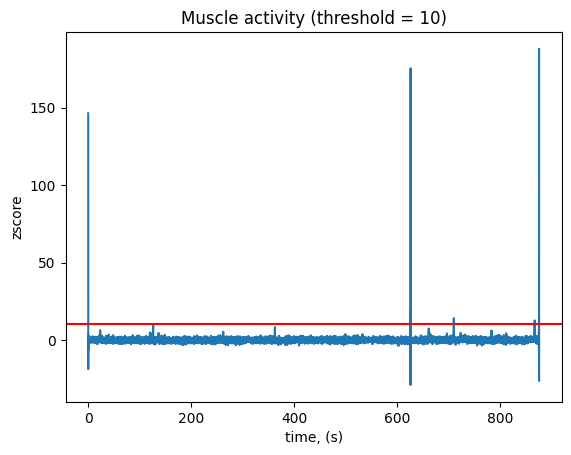

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
fig1, ax = plt.subplots()
ax.plot(raw_sss.times, scores_muscle)
ax.axhline(y=threshold_muscle, color='r')
ax.set(xlabel='time, (s)', ylabel='zscore', title='Muscle activity (threshold = %s)' % threshold_muscle)

In [15]:
raw_sss.set_annotations(annot_muscle)

<Raw | mg99a01.fif, 310 x 875000 (875.0 s), ~2.03 GB, data loaded>

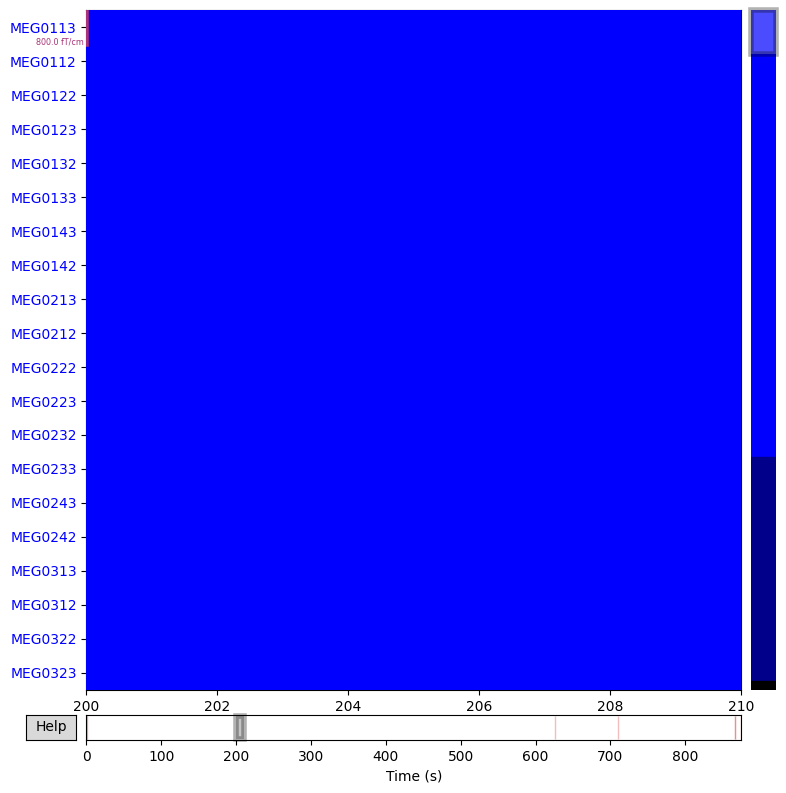

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 200.00 Hz
- Upper transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 225.00 Hz)
- Filter length: 3301 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.3s finished


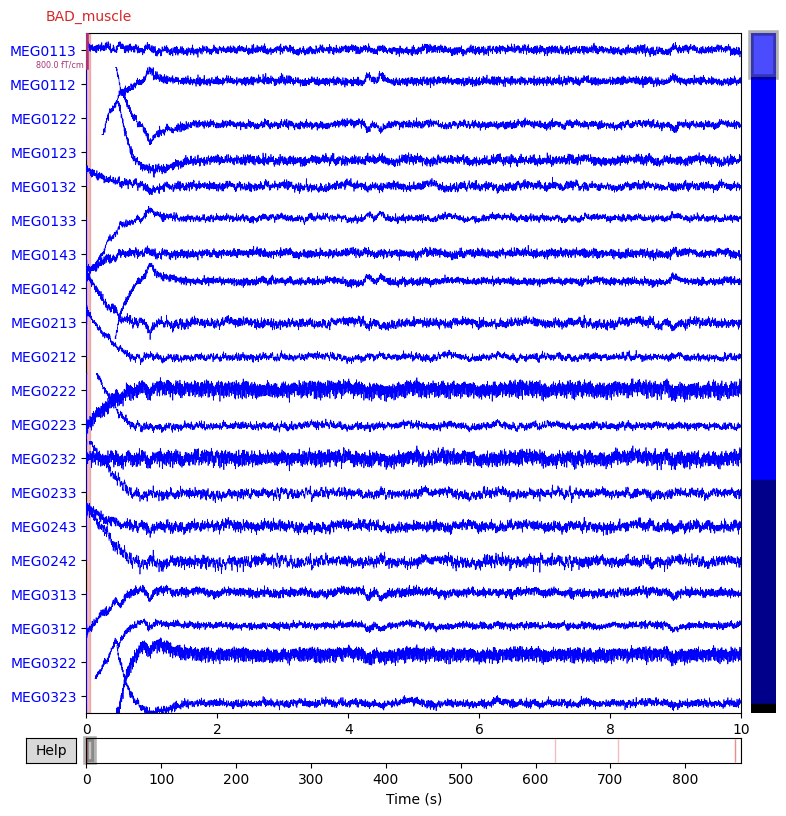

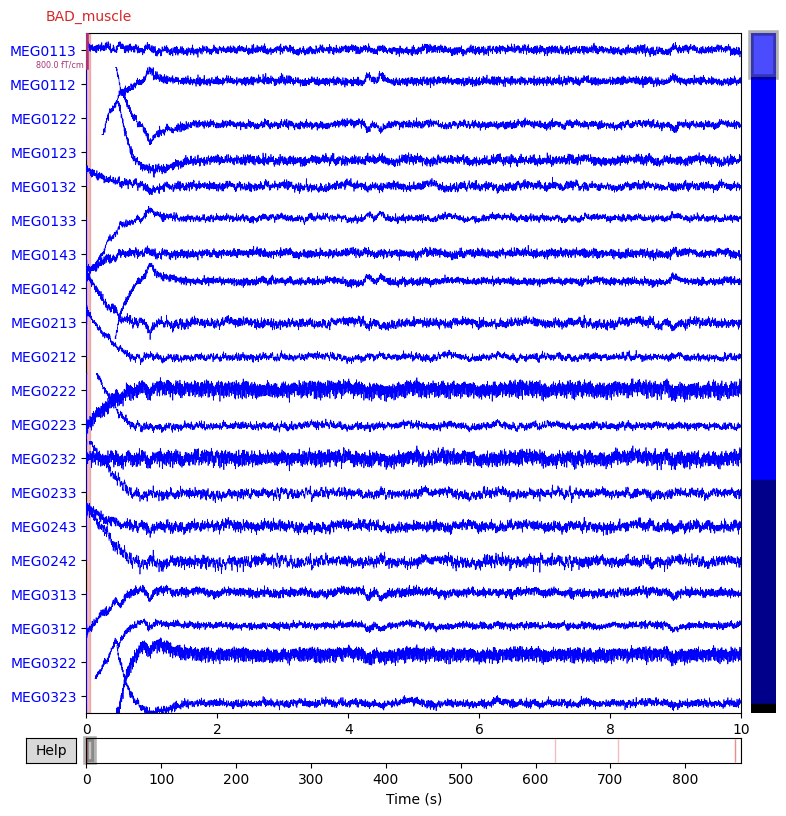

In [19]:
raw_sss.set_annotations(annot_muscle)
%matplotlib inline
raw_sss.plot(start=200)
raw_sss.copy().filter(1,200).plot()

In [22]:
out_path = 'D:\projects\WM_GRID\DATA\mg99a_out'

fname_out = op.join(out_path,
                    file_name + '_artif.fif')
raw_sss.save(fname_out, overwrite=True)

Overwriting existing file.
Writing D:\projects\WM_GRID\DATA\mg99a_out\mg99a01_artif.fif


C:\Users\qiaol\AppData\Local\Temp\ipykernel_616\390900379.py:5: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a_out\mg99a01_artif.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_sss.save(fname_out, overwrite=True)


Closing D:\projects\WM_GRID\DATA\mg99a_out\mg99a01_artif.fif
[done]


In [ ]:
events = mne.find_events(raw_sss,
                        stim_channel='STI101',
                        consecutive = True,
                        min_duration=0.001001)
events = events[events[:,2] != 255]
events = np.concatenate([events],axis = 0)
events = events[events[:,0].argsort(),:]
        
# Show events
fig = mne.viz.plot_events(events)

In [ ]:
# Save event array
fname_events = op.join(out_path,
                        file_name + '-eve.fif')                            
mne.write_events(fname_events, events)

In [8]:
import os.path as op
import os
# import sys
import matplotlib.pyplot as plt
from fpdf import FPDF

import mne
from mne.preprocessing import ICA
# Filter and resampling params
l_freq = 1
h_freq = 40
sfreq = 200
file_name = 'mg99a01'
out_path = 'D:\projects\WM_GRID\DATA\mg99a_out'

# ICA SETTINGS
# =============================================================================

ica_method = 'fastica'
n_components = 0.99
max_iter = 800
random_state = 1688

raw_fname_in = op.join(out_path,
                        file_name + '_artif.fif')
raw = mne.io.read_raw_fif(
            raw_fname_in, 
            preload=True, 
            verbose='error')
        
# Downsample copy of raw
raw_resmpl = raw.copy().resample(sfreq)
            
# Band-pass filter raw copy
raw_resmpl.filter(l_freq, h_freq)

ica = ICA(method=ica_method,
            random_state=random_state,
            n_components=n_components,
            verbose=True)

360 events found
Event IDs: [101 102 103 104 111 112 121 122 123]
360 events found
Event IDs: [101 102 103 104 111 112 121 122 123]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    0.9s finished


Fitting ICA to data using 306 channels (please be patient, this may take a while)
Omitting 223 of 175000 (0.13%) samples, retaining 174777 (99.87%) samples.
Selecting by explained variance: 59 components
Fitting ICA took 27.1s.
Creating RawArray with float64 data, n_channels=59, n_times=175000
    Range : 14400 ... 189399 =     72.000 ...   946.995 secs
Ready.
Using matplotlib as 2D backend.


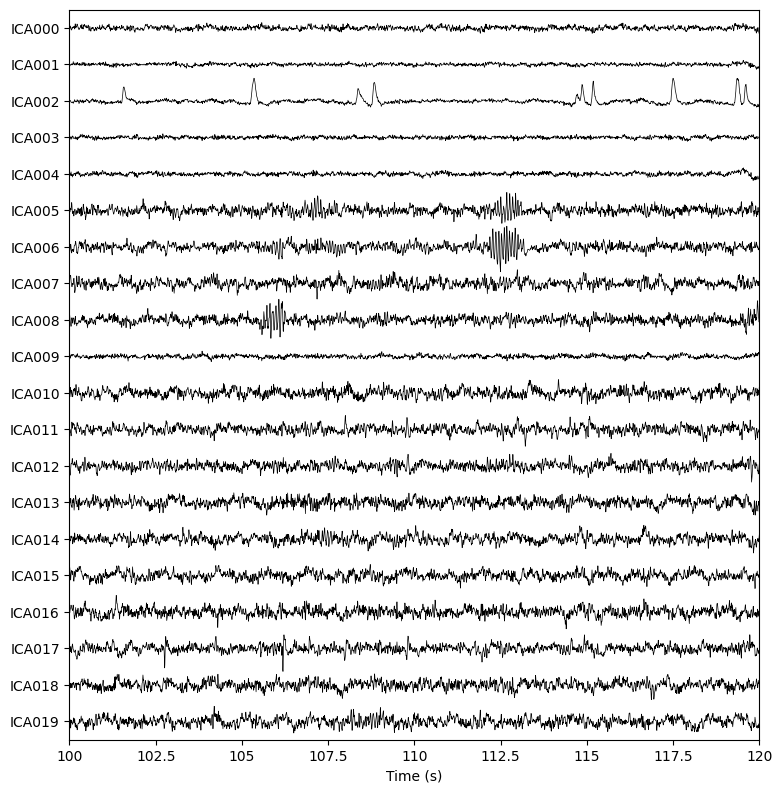

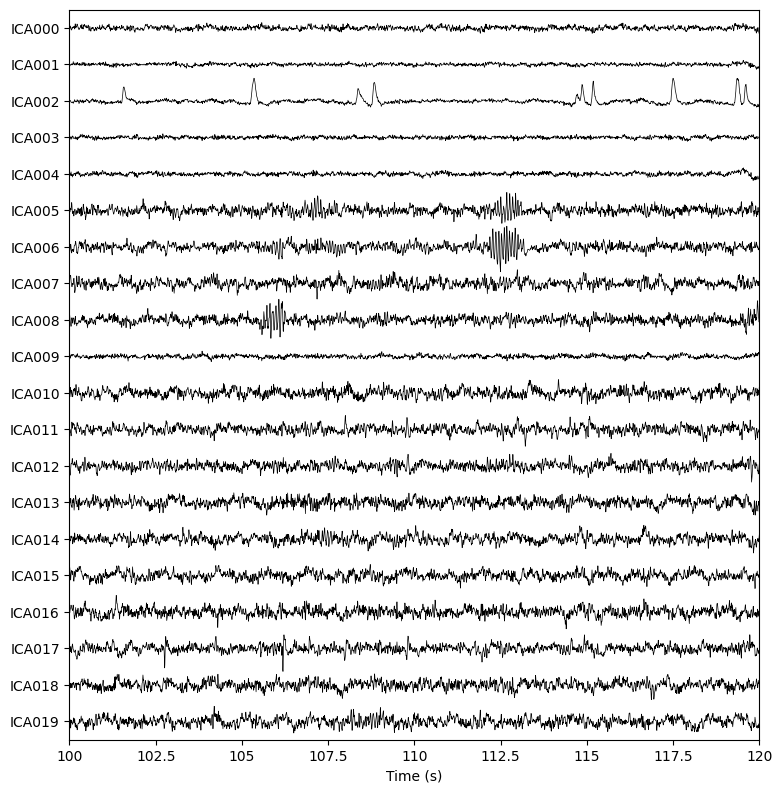

In [9]:
ica.fit(raw_resmpl,
        picks='meg',
        verbose=True)
    
# Plot timecourse of estimated sources
ica.plot_sources(raw_resmpl,
                        start=100,
                        show_scrollbars=False,
                        title='ICA_MEG')
    

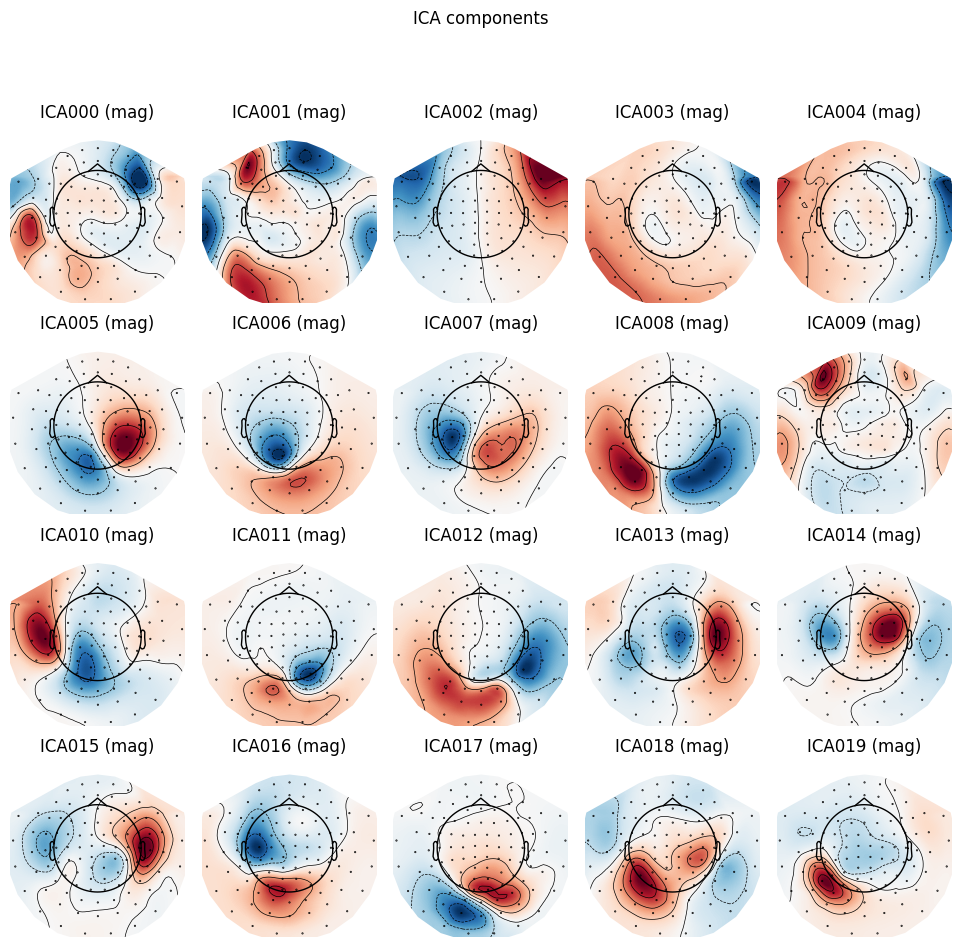

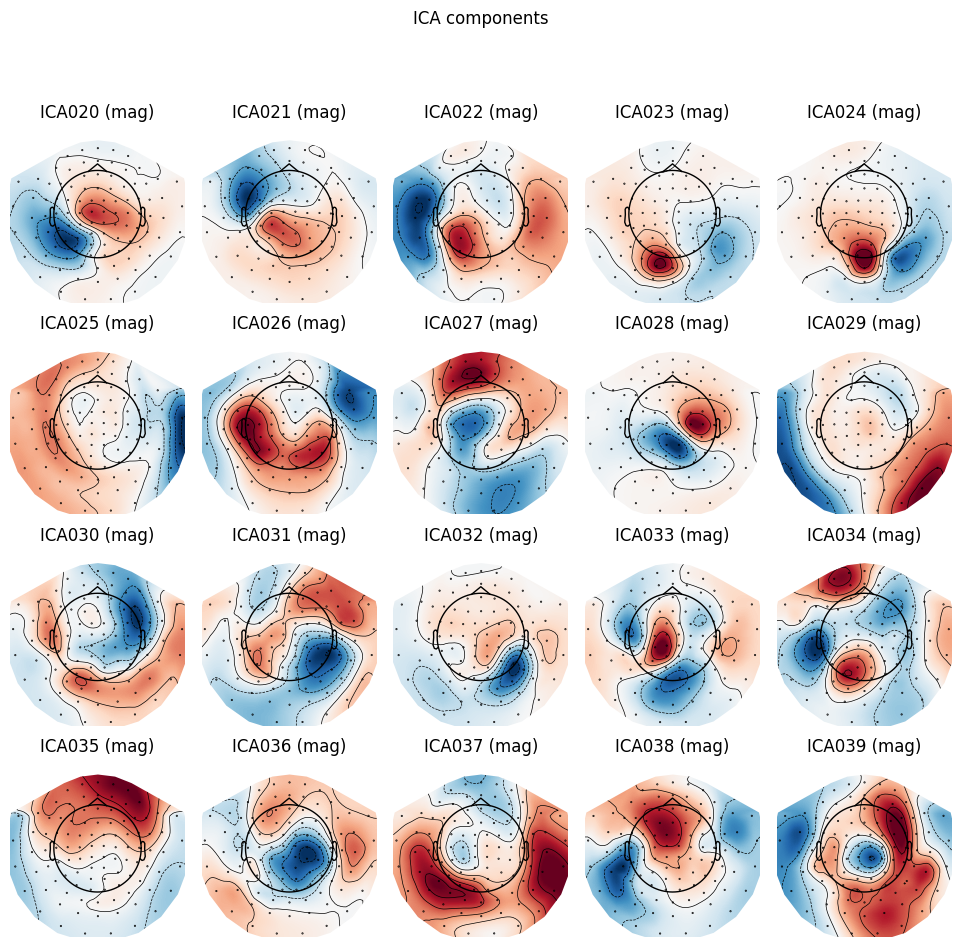

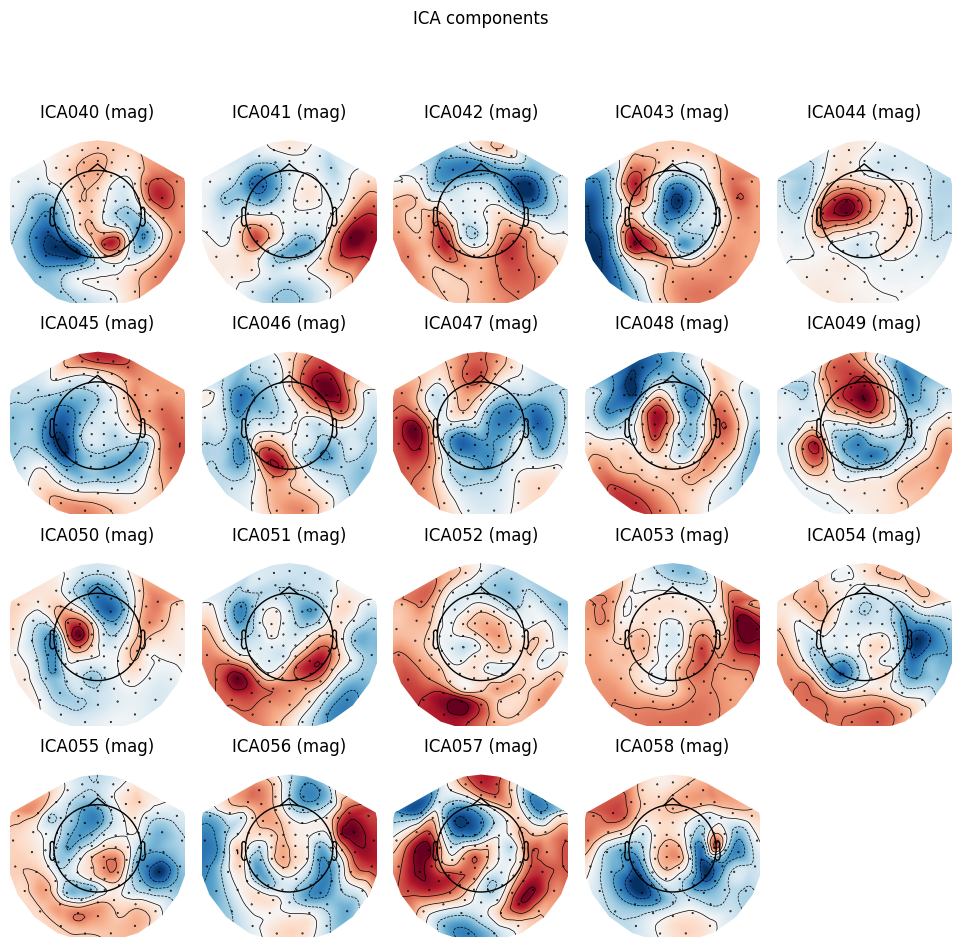

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 19 Axes>]

In [10]:
%matplotlib inline
ica.plot_components()

In [11]:
from mne.preprocessing import read_ica
ica_fname = op.join(out_path,
                    file_name[0:14] + 'ica_meg.fif')
ica.save(ica_fname,overwrite=True)
ica_fname = op.join(out_path,
                    file_name[0:14] + 'ica_meg.fif')
ica = read_ica(ica_fname)

Overwriting existing file.
Writing ICA solution to D:\projects\WM_GRID\DATA\mg99a_out\mg99a01ica_meg.fif...


C:\Users\qiaol\AppData\Local\Temp\ipykernel_29300\3711010593.py:4: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a_out\mg99a01ica_meg.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(ica_fname,overwrite=True)


Reading D:\projects\WM_GRID\DATA\mg99a_out\mg99a01ica_meg.fif ...
Now restoring ICA solution ...
Ready.


C:\Users\qiaol\AppData\Local\Temp\ipykernel_29300\3711010593.py:7: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a_out\mg99a01ica_meg.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica = read_ica(ica_fname)


In [14]:
# Set the components to exclude
ica.exclude = [2]
raw_ica = raw.copy()
ica.apply(raw_ica)
fname_out = op.join(out_path,
                    file_name + '_ica.fif')
raw_ica.save(fname_out,overwrite=True)

Applying ICA to Raw instance
    Transforming to ICA space (59 components)
    Zeroing out 1 ICA component
    Projecting back using 306 PCA components
Writing D:\projects\WM_GRID\DATA\mg99a_out\mg99a01_ica.fif


C:\Users\qiaol\AppData\Local\Temp\ipykernel_29300\834002238.py:7: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a_out\mg99a01_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_ica.save(fname_out,overwrite=True)


Closing D:\projects\WM_GRID\DATA\mg99a_out\mg99a01_ica.fif
[done]


In [15]:
# Read raw data
file_name = 'mg99a01'
out_path = 'D:\projects\WM_GRID\DATA\mg99a_out'
raw_fname_in = op.join(out_path,
                        file_name + '_ica.fif')
raw_tmp = mne.io.read_raw_fif(
            raw_fname_in, 
            preload=False, 
            verbose='error')
events_tmp = mne.read_events(op.join(out_path,
                                    file_name + '-eve.fif'))